# Falcon 9 Max-Q Thrust Analysis
This project from 2022 is about finding out how much Falcon 9 throttles down when reaching Max-Q.

**To do this I used the following information:**
1. Thrust of the first stage (7607 kN src: https://www.spacex.com/vehicles/falcon-9/)
2. Speed of the vehicle during launch (provided by SpaceX webcast imagery src: https://www.youtube.com/watch?v=xpl_JnG7rcg)

I assumed that the vehicle is on full thrust until and after Max-Q. 

**Steps:**
1. Trim original SpaceX video and extract one frame per second.
1. Extract speed value by using EasyOCR and store in csv
1. Loading data and plotting time-velocity diagram
1. Calculating acceleration
1. Calculating mass 
1. Calculating real thrus

## Loading data and plotting time-velocity diagram

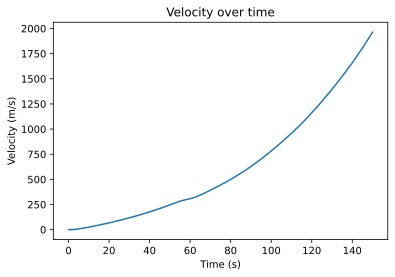

In [1]:
import pandas as pd
from pltgraph import plt_data
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("videodata.csv")
csvdata = [df.Time.tolist(), df.Velocity.tolist()]

time = [int(t) for t in csvdata[0]]
velocity = [ v / 3.6 for v in csvdata[1]]

description = {
    "title": "Velocity over time",
    "xLable": "Time (s)",
    "yLable": "Velocity (m/s)"
}

plt_data(time, velocity, description)

## Calculating acceleration
The acceleration is calculated via the difference in velocity:

$a = \frac{\Delta v} {\Delta t}$

Because you have to have two values to calculate the differnz between them, the resulting list will be one value shorter than the list of time values. So the first value of the time list is removed to make both list the same lenght.

In [ ]:
acceleration = []
for idx in range(len(time)):
    if idx == 0: continue
    acceleration.append((velocity[idx] - velocity[idx -1]) / (time[idx] - time[idx-1]))

time = time[1:]

description = {
    "title": "Acceleration over time",
    "xLable": "Time (s)",
    "yLable": "Acceleration (m/s^2)"
}

plt_data(time, acceleration, description)

We can see, that there is a drop in acceleration between 53s and 65s, which happens to be before Max-Q at 75s.  
The spike at around 125s is probaly just an data capturing issue.

## Calculating mass
To get the thrust of the vehicle at each point in time, we have to know it's mass and acceleration at each point in time: $F = m * a$  
We now have the acceleration values, but we don't know it's mass, because by burning fuel during launch, the vehicle gets lighter. To calculate that, we can assume that the vehicle is on full thrust the whole time (even if we know that during Max-Q that is not the case). 

There are two forces acting on the vehicle:  
1. The thrust provided by the engines of the rocket: $F_T = m * a_T$
2. The weight of the vehicle: $F_G = m * g$

So the resulting force is the differnze between them: $F_R = F_T - F_G = m * a_R$

$a_R$ is the acceleration we just calculated  
$F_T = 7607 kN$ (Thrust of the rocket)

$$ m = \frac {F_T}{a_R + g} $$

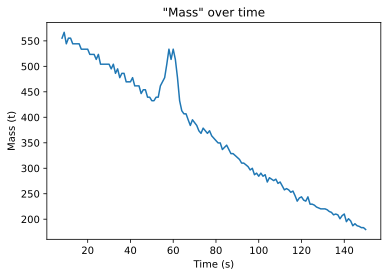

In [3]:
F = 7607000 
g = 9.81

mass = [F / (a+g) for a in acceleration]

description = {
    "title": '"Mass" over time',
    "xLable": "Time (s)",
    "yLable": "Mass (t)"
}

time = time[7:]
mass = mass[7:]
plt_data(time, [m / 1000 for m in mass], description)

The first 4s are removed, because values where to low and fluctuating.  

Mass at liftoff is ca. 550t as it is on SpaceX's website, so we can assume our calculation were correct so far.  
 
The loss of mass is quiet linear (except around Max-Q), which it has to be if the rate of the fuel burned per second stays the same. But at Max-Q the vehicle throttles down, so our calculated mass is too high. To still get the "missing" mass values we can draw a regression line. 

We take the fist and one of the last values and calculate the slope of the regression line:  $m = \frac{\Delta y} {\Delta x}$  
The y-intercept is the first mass value + some finetuning 


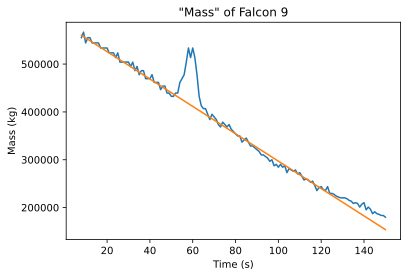

In [4]:
d_y = mass[120] - mass[4]
d_x = time[120] - time[4]

m = d_y/d_x

true_mass = [m*x + mass[0] + 28000 for x in time]

description = {
    "title": '"Mass" of Falcon 9',
    "xLable": "Time (s)",
    "yLable": "Mass (kg)",
}

plt_data(time, (mass, true_mass), description)

## Calculating real thrust
Now we have the true mass for every point in time and are able to calculate the actual thrust by using this equation: 
$$ F_T = F_R + F_G  $$
$$ F_T = m * a_R + m * g $$

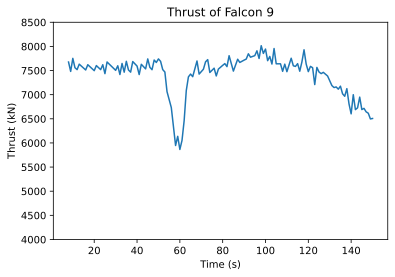

In [5]:
thrust = []

for m, a in zip(true_mass, acceleration[7:]):
    thrust.append(m * a + m*g)


description = {
    "title": 'Thrust of Falcon 9',
    "xLable": "Time (s)",
    "yLable": "Thrust (kN)",
    "ylims": (4000,8500)
}

plt_data(time, [i / 1000 for i in thrust], description)

We can see that the average thrust matches the 7607 kN on SpaceX's website.  
Now we want to get the percentage of how much the vehicle throttles the engine.

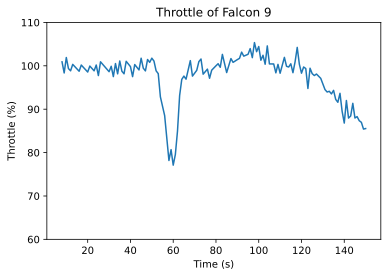

In [6]:
throttle = [(t / F) * 100 for t in thrust]

description = {
    "title": 'Throttle of Falcon 9',
    "xLable": "Time (s)",
    "yLable": "Throttle (%)",
    "ylims": (60,110)
}

plt_data(time,throttle, description)

It's now clear to see, that the vehicle is on full thrust until 53s where it throttles down to ca. 75 %. Surprisingly it throttles up to 100% at 65s, 10s before Max-Q. In the last seconds before MECO, the vehicle seems to throttle down too. 